# Sentiment Analysis over Time and Space

This project is to:
- Do sentiment analysis with twitter data
- Use the datetime module to track the use of positive and negative emoji over time
- Use geopandas and plotly to display the sentiment associated with topics in different US states

## 1. Import Packages

Several python modules need to be installed for this project, including Geopandas. Geopandas has a number of dependencies that can require manual installation on Windows, see [this blog post]((https://geoffboeing.com/2014/09/using-geopandas-windows/).

In [1]:
#pip install geopandas
#pip install shapely
#pip install plotly
#pip install emoji
#pip install vaderSentiment

Run the code below to access relevant modules (you can add to this as needed)

In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import emoji
import json
import zipfile
import csv
from pytz import timezone
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import urllib.request
import plotly.express as px
from IPython.display import Image
pd.plotting.register_matplotlib_converters() # might be needed to plot datetimes correctly

## 2. Data Preprocessing

In this project, I will use a collection of tweets from the years 2013-2015.

### 2.1. Import the Data

- The twitter data used in the project can be downloaded from [here](https://drive.google.com/open?id=14-oVzHygSO6NhFh27OIIjKid7cqNJ0i5). Do not unzip the file.

Modify the path so it points to the twitter data.

In [2]:
#provided code
twitter_data_path = "data/tweets-2013-5.zip"

### 2.2. Load the Data

In [4]:
all_tweets = {}

# access the provided zipfile directly, without unzipping it, using the zipfile library
with zipfile.ZipFile(twitter_data_path) as myzip:
    # Inside the zipfile are three files, one for each year. Access each file using zipfile's "namelist" function
    for filename in myzip.namelist():
        tweets = []
        with myzip.open(filename) as myfile:
            for line in myfile.readlines():
                # Each file has one tweet per line, in json format
                tweet = json.loads(line.decode("utf-8"))
                # Exclude any tweet which is not from the US
                if tweet['place'] and tweet['place']['country_code'] == 'US':
                    tweets.append(tweet)
        all_tweets[filename] = tweets

### 2.3. Examine the Data

Print out the number of tweets for each year.

In [6]:
for year,tweets in all_tweets.items():
    print(year)
    print(len(tweets))

tweet_us_2013_subset.txt
79431
tweet_us_2014_subset.txt
89448
tweet_us_2015_subset.txt
93032


Print out the longitude, latitude, the date, and the time of the first tweet in the 2013 set.

In [7]:
first_tweet = all_tweets["tweet_us_2013_subset.txt"][0]
print("longitude: ", first_tweet['coordinates'][0])
print("latitude: ", first_tweet['coordinates'][1])
tweet_datetime = datetime.datetime.strptime(first_tweet['created_at'], "%a %b %d %H:%M:%S %z %Y")
print("date: ", tweet_datetime.date().strftime('%a %b %d %Y'))
print("time: ", tweet_datetime.time())

longitude:  -122.2469221
latitude:  47.7470274
date:  Tue Jan 01 2013
time:  00:00:32


In [8]:
first_tweet

{'created_at': 'Tue Jan 01 00:00:32 +0000 2013',
 'id': 285898264618864640,
 'id_str': '285898264618864640',
 'text': "It's nights like tonight that I wish I was with my sisters #xilove #missthem #onemoreweek #xoxi",
 'truncated': False,
 'entities': {'hashtags': [{'text': 'xilove', 'indices': [59, 66]},
   {'text': 'missthem', 'indices': [67, 76]},
   {'text': 'onemoreweek', 'indices': [77, 89]},
   {'text': 'xoxi', 'indices': [90, 95]}],
  'symbols': [],
  'user_mentions': [],
  'urls': []},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 120961615,
  'id_str': '120961615',
  'name': 'Haley Brown',
  'screen_name': 'Hkaybrown',
  'location': 'Cheney, WA',
  'description': 'Alpha Xi Delta. Eastern Washington University. Soccer. Family. Friends.',
  'url': 

The text of the tweet is found in the `text`.  Find one tweet in the twitter corpus whose text contains an example of each of the following items.

- Emoji
- Emoticons

In [9]:
Emoji=False
Emoticons=False

all_emoji = emoji.UNICODE_EMOJI['en']


for i in range(len(all_tweets['tweet_us_2013_subset.txt'])):
    tweet = all_tweets['tweet_us_2013_subset.txt'][i]['text']
    
    # Emoji
    if Emoji==False:
        for element in list(tweet):
            if element in all_emoji:
                Emoji = True
                print("Emoji: ", tweet)
                break
            
    # Emoticons
    if Emoticons == False:
        if ':(' in tweet:
            Emoticons = True
            print("Emoticons: ", tweet)
            
    # break the loop when the examples of emojis and emoticons are found
    if Emoji and Emoticons:
        break

Emoji:  @Keyaa_ LOL ew no I'm allergic to vodka!😖😖😖😖
Emoticons:  #oomf is acting stupid :(


## 3. Emoji Time

### 3.1. Emoji and Emoticon

For each of the three years, count the percentage of tweets which contain an emoji.

In [10]:
for all_tweet in all_tweets.keys():
    
    count = 0
    pos = 0
    for i in range(len(all_tweets[all_tweet])):
        count+=1
        tweet = all_tweets[all_tweet][i]['text']
        for element in list(tweet):
            if element in all_emoji:
                pos+=1
                break
                
    print("{}% of tweets contain an emoji in {}:".format(round(100*pos/count,2), all_tweet[9:13]))


10.19% of tweets contain an emoji in 2013:
27.56% of tweets contain an emoji in 2014:
28.56% of tweets contain an emoji in 2015:


**The use of emoji increases over time.**

In [11]:
for all_tweet in all_tweets.keys():
    
    count = 0
    pos = 0
    for i in range(len(all_tweets[all_tweet])):
        count+=1
        tweet = all_tweets[all_tweet][i]['text']
        if ':)' in tweet:
            pos+=1
 
    print("{}% of tweets contain an emoticon in {}:".format(round(100*pos/count,2), all_tweet[9:13]))

1.83% of tweets contain an emoticon in 2013:
0.56% of tweets contain an emoticon in 2014:
0.45% of tweets contain an emoticon in 2015:


**People tend to use less emoticon over time, which is possible because of the prevalence of the emoji. "One man's loss is another's gain."**

### 3.2. Sentiment polarity by Emoji

The code below uses the provided "Emoji_Sentiment_Data_v1.0.csv" file to build a list of positive and negative emoji. 

In [13]:
positive_emoji = set()
negative_emoji = set()

f = open("Emoji_Sentiment_Data_v1.0.csv",encoding="utf-8")
reader = csv.DictReader(f)
for row in reader:
    pos_count = int(row["Positive"])
    neg_count = int(row["Negative"])
    if pos_count > 50 and pos_count > neg_count*1.5 :
        positive_emoji.add(row["Emoji"])
    elif neg_count > 50 and neg_count > pos_count*1.5 :
        negative_emoji.add(row["Emoji"])   

The two functions `pos_emoji_count` and `neg_emoji_count` count the number of positive and negative emoji in the text of a tweet. 

In [15]:
def pos_emoji_count(tweet_text):
    ''' count the number of positive emoji in the text of a tweet'''
    count=0
    for element in list(tweet_text):
        if element in positive_emoji:
            count+=1
    return count

def neg_emoji_count(tweet_text):
    ''' count the number of negative emoji in the text of a tweet'''
    count=0
    for element in list(tweet_text):
        if element in negative_emoji:
            count+=1
    return count

Test code to make sure the two functions work:

In [16]:
emoji_tweet = "😎😎👎"
assert pos_emoji_count(emoji_tweet) == 2
assert neg_emoji_count(emoji_tweet) == 1
print("Success!")

Success!


### 3.3. Sentiment Change Over Time

To graph the frequency of positive and negative emoji at particular times of day. However, tweets are timestamped with UTC time (otherwise known as Greenwich Mean Time, the time in the UK), not the local time of the tweeter. This will disrupt our analysis because tweets from different parts of the US will be out of sync.

 

In [17]:
# These are the rough timezone boundaries to convert the time to local time the tweet was created
pacific_mountain_boundary = -115
mountain_central_boundary = -100
central_eastern_boundary = -85

The function below `get_local_time` takes a tweet and uses its longitude (along with the rough timezone boundaries provided above) to update its timezone (There are only 4 main timezones of the continential US: Pacific, Mountain, Central, and Eastern), returning a *time* object (NOT a datetime object) which has the local time the tweet was created. 

In [18]:
def get_local_time(tweet):
    
    '''this function takes a tweet json with a GTC datetime and returns a datetime.time object which has the local time
    based on the time zone derived from the coordinates of the tweet'''
    
    dt = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y')
    longitude = tweet["coordinates"][0]
    if longitude <= pacific_mountain_boundary:
        local_dt = dt.astimezone(timezone("US/Pacific"))
    if pacific_mountain_boundary < longitude <= mountain_central_boundary:
        local_dt = dt.astimezone(timezone('US/Mountain'))
    if mountain_central_boundary < longitude <= central_eastern_boundary:
        local_dt = dt.astimezone(timezone('US/Central'))
    if central_eastern_boundary < longitude:
        local_dt = dt.astimezone(timezone('US/Eastern'))
    return local_dt.time()

Test code to make sure the `get_local_time()` function works:

In [19]:
part_tweet = {'coordinates': [-122.2469221, 47.7470274],'created_at': 'Tue Jan 01 00:00:32 +0000 2013'}
assert get_local_time(part_tweet) == datetime.time(16, 0, 32)
print("Success!")

Success!


Now, iterate over all the tweets in the collection and 
  * keep counts of how many positive and negative emoji during 30 minute periods throughout the day, like 12:00 am - 12:30 am, 12:30 am - 1:00 am, etc. 
  * Graph these counts, with a separate line for positive and negative emoji. Here I use [subplots](https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html) to see the patterns. For this graph, The x-axis labels are be time objects.

In [ ]:
pos_emoji_time = defaultdict(int)
neg_emoji_time = defaultdict(int)
for tweets in all_tweets.values():
    for tweet in tweets:
        hour = get_local_time(tweet).hour
        minute = get_local_time(tweet).minute
        if minute <= 30:
            key=hour
            #key = str(hour) + ':' + '00'
        else:
            key=hour+0.5
            #key = str(hour) + ':' + '30'
        pos_emoji_time[key] += pos_emoji_count(tweet['text'])
        neg_emoji_time[key] += neg_emoji_count(tweet['text'])
        
pos_emoji_time = sorted(pos_emoji_time.items())
neg_emoji_time = sorted(neg_emoji_time.items())

In [ ]:
x = [time for time, count in pos_emoji_time]
y_pos = [count for time, count in pos_emoji_time]
y_neg = [count for time, count in neg_emoji_time]

[Text(0.5, 0, 'time'), Text(0, 0.5, 'negative emoji count')]

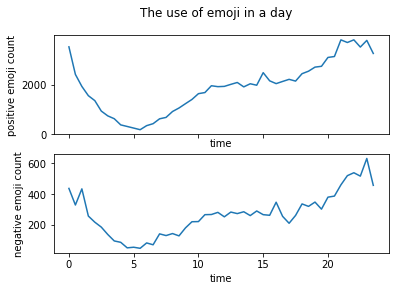

In [36]:
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('The use of emoji in a day')
axs[0].plot(x, y_pos)
axs[1].plot(x, y_neg)
axs[0].set(xlabel='time', ylabel='positive emoji count')
axs[1].set(xlabel='time', ylabel='negative emoji count')

Analysis for the graph:

**The positive and negative emoji counts have similar curves overall. This is because people have similar timetable in a day:**
- Sleep between 0:00 and 8:00, so the use of emoji goes down and remains low.
- The counts start going up from 8:00 to 17:00 but remains medium, because people are working in the day.
- After 17:00, people get off work and spend more time in social media.

**However, at some points the curves don't sync:**
- At about 1:00, there is an increase in negative emoji count. This is because people tend to be more negatively emotional at mid-night.
- There is a drop in negative emoji count around 17:00. I think this is because people are about to get off work or school, so they are more positive about the rest of the day.

<br><br><br><br>

### 4. The United States of Polarity

This part is to build Choropleths which show the sentiment of particular US states towards a chosen topic. For this, I use the following GEOJSON file.

In [37]:
US_states_geojson = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json"

Here I use an off-the-shelf Python package for doing (lexicon-based) sentiment analysis, the VADER sentiment analyzer. The code below is to access it (after installing the package). It provides a dictionary output which has positive, negative, and neutral scores, however I only use the single "compound" score here.

In [38]:
analyzer = SentimentIntensityAnalyzer()
sentence = "worst project ever"
scores = analyzer.polarity_scores(sentence)
print(scores)

{'neg': 0.672, 'neu': 0.328, 'pos': 0.0, 'compound': -0.6249}


Here are some examples that show that VADER correctly handles emoji, emoticons, intensification and negation with clitics (e.g. don't).

In [40]:
sentences = ["thanks😊", ":-(", "smile", "big smile", "I don't smile"]

for sent in sentences:
    print(analyzer.polarity_scores(sent))

{'neg': 0.0, 'neu': 0.252, 'pos': 0.748, 'compound': 0.836}
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3612}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}
{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}
{'neg': 0.513, 'neu': 0.487, 'pos': 0.0, 'compound': -0.2755}


<br>

The function `get_tweet_sentiment_by_state` is to:

* Iterate over the tweets
* For each tweet, create a shapely Point using its coordinates
* Iterate over the geometries in the geopandas data object, and see which one `contains` the point (there will be only one, so stop when you find it)
* Calculate the polarity for that tweet (the "compound" output from VADER), and add that to the list for that state
* Return the resulting dictionary (states as keys, which you can get from the geopanda object; values will just be lists of sentiment scores)

In [41]:
# Load the US state geoJSON into geopandas
gdf_us = gpd.read_file(US_states_geojson)

def get_tweet_sentiment_by_state(tweets):
    '''tweets is a list of tweet jsons. Calculates the sentiment for each lists and creates a dictionary which has
    a mapping from states to the sentiments of the tweets that occurred in that state'''
    state_sentiments = defaultdict(list)

    for tweet in tweets:
        shapely_point = Point(tuple(tweet['coordinates']))

        for i in range(len(gdf_us['geometry'])):
            geometry = gdf_us['geometry'][i]
            if geometry.contains(shapely_point):
                state = gdf_us['NAME'][i]
                sentiment_scores = analyzer.polarity_scores(tweet['text'])
                state_sentiments[state].append(sentiment_scores['compound'])

    return state_sentiments
    

Test code to make sure the `get_tweet_sentiment_by_state()` function works:

In [42]:
tweets = [{"coordinates": [ -122.2469221, 47.7470274], "text": "It's nights like tonight that I wish I was with my sisters #xilove #missthem #onemoreweek #xoxi"}]
sentiments = get_tweet_sentiment_by_state(tweets)
assert list(sentiments.keys())[0] == "Washington"
assert list(sentiments.values())[0][0] == 0.6369
print("Success!")

Success!


The function is to convert the dictionary of state_sentiments from `get_tweet_sentiment_by_state()` into a dataframe with 3 columns: "NAME", "POLARITY", and "NUMTWEETS". Each row is a state with NAME, whose average polarity is POLARITY and whose total number of tweets is NUMTWEETS. 

Any state which has a NUMTWEETS less than min_tweets are excluded. 

In [44]:
def convert_to_df(state_sentiments,min_tweets):
    '''Convert the information in state_sentiments into a 3-column dataframe consisting of the state NAME, its POLARITY, and the
    NUMTWEETS. States whose number of tweets is less than min_tweets should be excluded'''

    state_sentiments_df = defaultdict(list)
    for state, scores in state_sentiments.items():
        if len(scores) >= min_tweets:
            state_sentiments_df['NAME'].append(state)
            state_sentiments_df['POLARITY'].append(sum(scores)/len(scores))
            state_sentiments_df['NUMTWEETS'].append(len(scores))
            
    return pd.DataFrame(state_sentiments_df)

Test code to make sure the `convert_to_df()` function works:

In [46]:
df = convert_to_df(get_tweet_sentiment_by_state(tweets),1)
df.head()

,NAME,POLARITY,NUMTWEETS
0,Washington,0.6369,1


The last function `print_state_choroplath()` takes two arguments, a string `search_string` that can be used to filter tweets and a minimum number of tweets required in order for a state to appear in the choroplath. The function:

* iterate over all your tweets and pull out those tweets where `search_string` appears (the match should be case INSENSITIVE)
* call `get_tweet_sentiment_by_state` and `convert_to_df` with the tweets to prepare the data
* call the `load_geojson` function provided below to prepare the geojson
* Create a plotly choroplath using the information you have created. Here is how the choroplath looks like:
  * It is centered on the continental United States. Alaska, Hawaii, and US territores are ignored
  * Negative is indicated by blue, positive by red
  * The tooltip that pops up when hovering over each step includes the states NAMES, its POLARITY, and its NUMTWEETS

In [47]:
def load_geojson():
    geojson_us = json.loads(urllib.request.urlopen(US_states_geojson).read().decode("utf-8"))
    for state in geojson_us["features"]:
        state["id"] = state["properties"]["NAME"]
    return geojson_us

In [48]:
def print_state_chorolopath(search_string,min_tweets): 
    '''Given a search_string and a min_tweets per state, construct and display a choroplath showing the sentiment of tweets
    containing the search string for states which meet the minimum tweet restriction'''

    related_tweets=[]
    for key, tweets in all_tweets.items():
        for tweet in tweets:
            if search_string.lower() in tweet['text'].lower():
                related_tweets.append(tweet)
    state_sentiments_df = convert_to_df(get_tweet_sentiment_by_state(related_tweets),min_tweets)
    geojson_us = load_geojson()
    fig = px.choropleth(state_sentiments_df, 
                        geojson=geojson_us, 
                        color="POLARITY",
                        locations="NAME", 
                        projection="mercator",
                        color_continuous_scale="bluered",
                        hover_data=["NAME", "POLARITY", "NUMTWEETS"]
                   )
    fig.update_geos(fitbounds="locations")

    return fig.to_image(format='png')

In [49]:
image_bytes = print_state_chorolopath("beer",5)

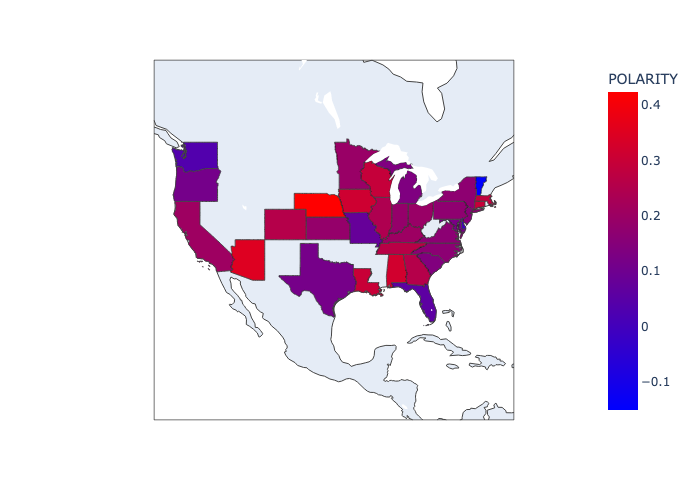

In [50]:
Image(image_bytes)

**People in the US have an overall positive sentiment about beer. Some states in the middle like Nebraska and Colorado are more passionate about beer.**

Now Let's try out many possible input searches and look at the results.

In [51]:
image_bytes_2 = print_state_chorolopath("gay",5)

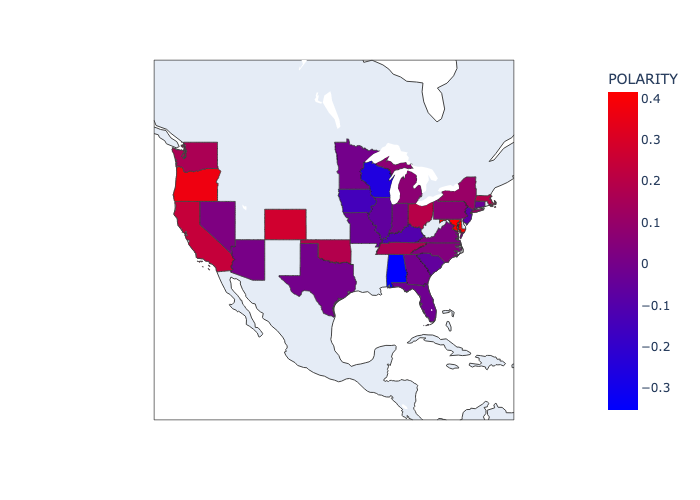

In [52]:
Image(image_bytes_2)

**We find that the developed states in the US are more positive about "LGBTQ", which is exactly a great and plausible indication.(I used keyword "gay" here because there are only a few tweets mentioned "LGBT")**

In [72]:
image_bytes_3 = print_state_chorolopath("drug",5)

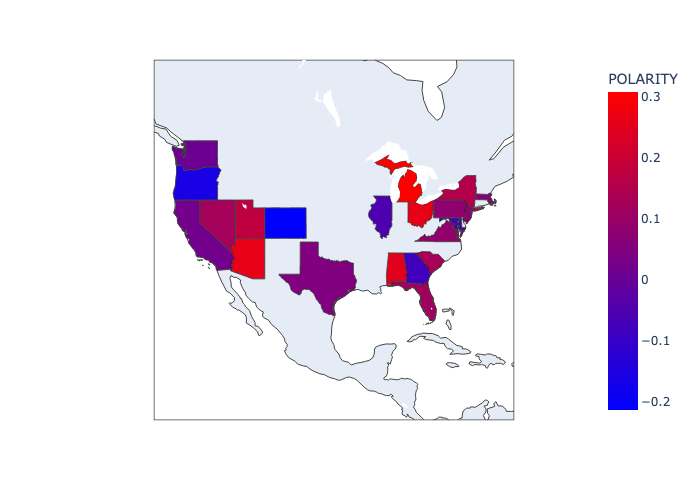

In [73]:
Image(image_bytes_3)

**From the data above, we find the states Oregon and Colorado are very negative about drug use. I think this is because of the ["Illicit Drug Use"](https://www.samhsa.gov/data/sites/default/files/cbhsq-reports/NSDUHsaeMaps2017/NSDUHsaeMaps2017.htm) is very serious in these states.**

In [79]:
image_bytes_4 = print_state_chorolopath("abortion",2)

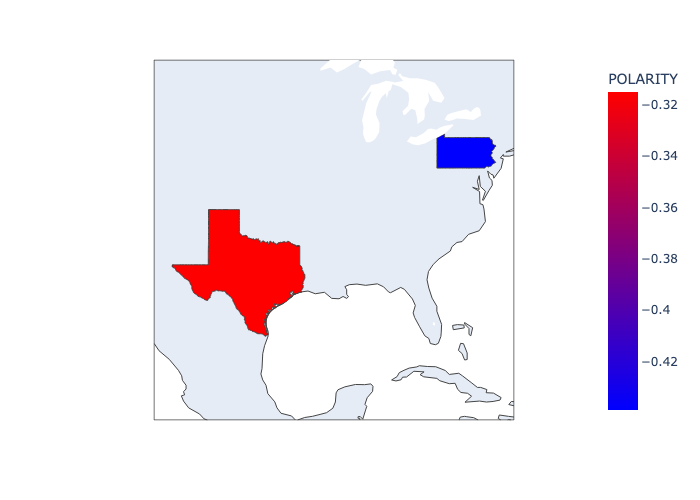

In [80]:
Image(image_bytes_4)

**We find abortion is mostly mentioned in Texas and Pennsylvania and both states are very negative about the issue. Texas has always been one of the most strict states in the US about abortion.**

In [99]:
image_bytes_5 = print_state_chorolopath("republican",2)

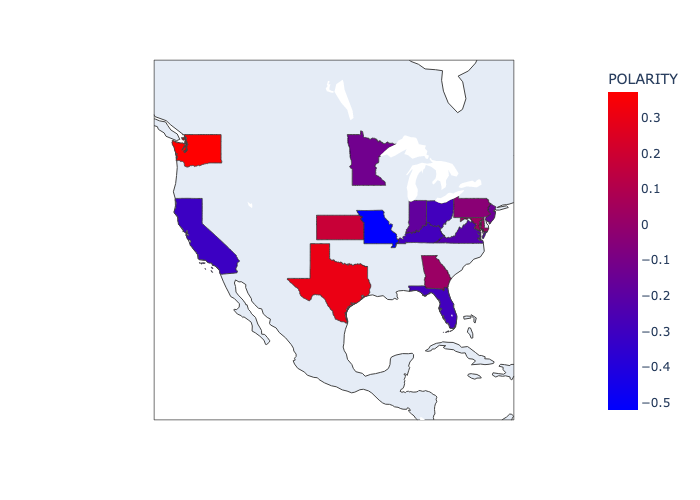

In [100]:
Image(image_bytes_5)

**We find that during 2013-2015, people in Texas are most positive about Republican. This totally makes sense, because Texas always has the most supporters for Republican.**

In [85]:
image_bytes_6 = print_state_chorolopath("christ",5)

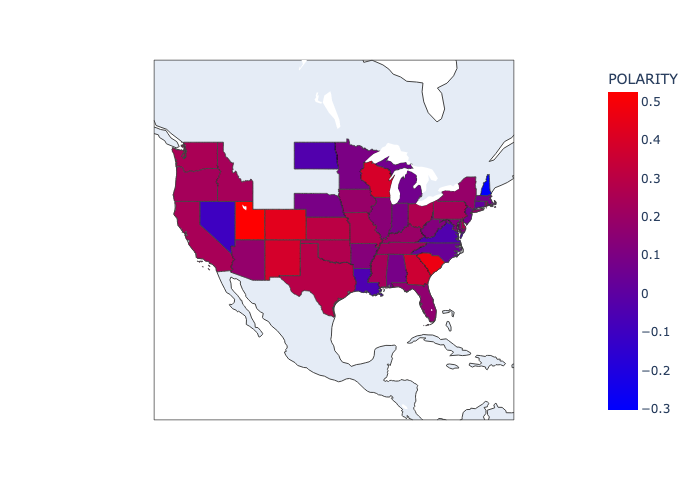

In [86]:
Image(image_bytes_6)

**We find the Utah state is most positive about "Christ", this is very plausible, because from [the data reported](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_religiosity), people in Utah have the highest attendance in church.**